In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import time

#%matplotlib widget
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical

# IO utils


In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [3]:
palm_file = './data/2023-05-31_17-14-41.palm'
gestures = read_omg_csv(palm_file, 
                              n_omg_channels=50,
                              n_acc_channels=3, 
                              n_gyr_channels=3, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print(gestures.shape)
gestures.head()

(19568, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,12,8,5,6,2,4,5,7,14,8,...,-13,0,0,0,0,0,0,0,0,555777
1,13,8,4,5,3,0,5,4,9,10,...,-16,0,0,0,0,0,0,0,0,555810
2,12,5,9,5,0,0,6,5,10,9,...,-14,0,0,0,0,0,0,0,0,555843
3,10,7,6,4,1,0,4,6,7,8,...,-12,0,0,0,0,0,0,0,0,555876
4,12,6,6,7,3,2,6,7,9,12,...,-12,0,0,0,0,0,0,0,0,555909


In [4]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [5]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


In [6]:
#!!! # Применение скользящего среднего
"""window_size = 2  # Размер окна для скользящего среднего

# Применение скользящего среднего к каждому каналу оптомиографии
for column in OMG_CH:
    gestures[column] = gestures[column].rolling(window=window_size, min_periods=1).mean()

# Проверка обновленных данных
print("Data after applying moving average:")
print(gestures[OMG_CH].head())"""


'window_size = 2  # Размер окна для скользящего среднего\n\n# Применение скользящего среднего к каждому каналу оптомиографии\nfor column in OMG_CH:\n    gestures[column] = gestures[column].rolling(window=window_size, min_periods=1).mean()\n\n# Проверка обновленных данных\nprint("Data after applying moving average:")\nprint(gestures[OMG_CH].head())'

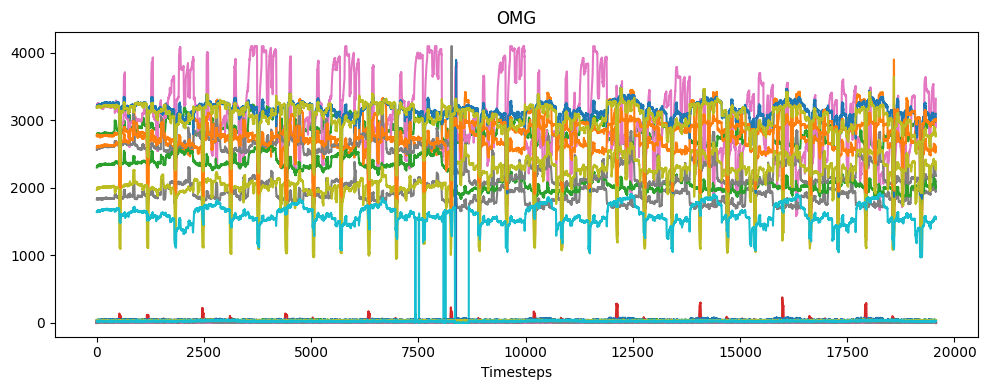

In [7]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

In [8]:
"""import pandas as pd
from sklearn.preprocessing import StandardScaler

# Определение столбцов для нормализации (например, все столбцы сенсоров)
columns_to_scale = OMG_CH  # Это должны быть имена столбцов данных сенсоров

# Создание экземпляра нормализатора
scaler = StandardScaler()

# Нормализация выбранных столбцов
gestures[columns_to_scale] = scaler.fit_transform(gestures[columns_to_scale])

# Проверка результатов нормализации
print("Data after normalization:")
print(gestures[columns_to_scale].head())"""


'import pandas as pd\nfrom sklearn.preprocessing import StandardScaler\n\n# Определение столбцов для нормализации (например, все столбцы сенсоров)\ncolumns_to_scale = OMG_CH  # Это должны быть имена столбцов данных сенсоров\n\n# Создание экземпляра нормализатора\nscaler = StandardScaler()\n\n# Нормализация выбранных столбцов\ngestures[columns_to_scale] = scaler.fit_transform(gestures[columns_to_scale])\n\n# Проверка результатов нормализации\nprint("Data after normalization:")\nprint(gestures[columns_to_scale].head())'

### Protocol

In [9]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
gestures_protocol.head(10)

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [10]:
gestures['SYNC'].value_counts()

0      11266
57        58
67        58
97        47
135       47
       ...  
52        46
1         45
103       45
104       45
12        39
Name: SYNC, Length: 181, dtype: int64

In [11]:
le = LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
    
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [12]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [13]:
gestures_protocol['gesture']

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 181, dtype: int64

In [14]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

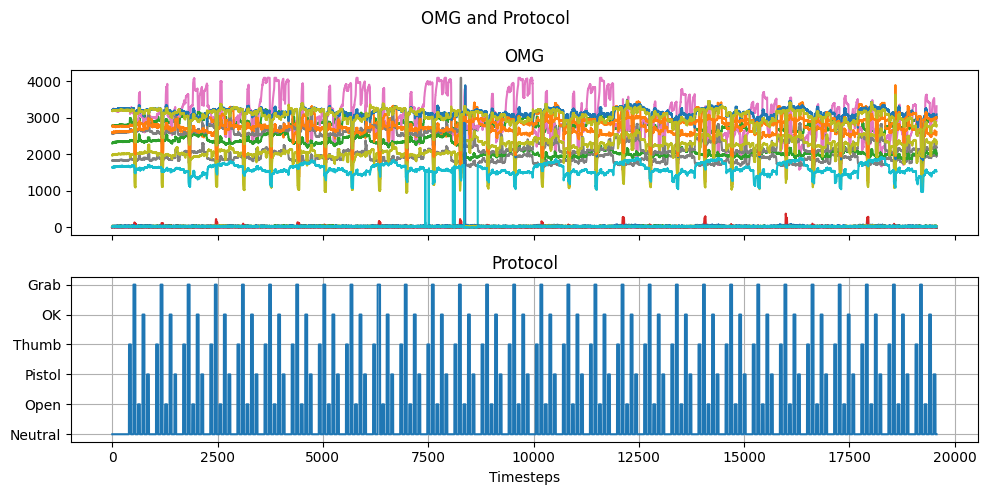

In [15]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

# Задержка

In [16]:
#Формируем целевой признак
gestures['gesture'] = gestures['SYNC'].apply(lambda x: gestures_protocol['gesture'].loc[x])
#Удаляем ненужный столбец
gestures2 = gestures.drop('SYNC', axis=1)
gestures2.head()

,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,ts,gesture
0,12,8,5,6,2,4,5,7,14,8,...,-13,0,0,0,0,0,0,0,555777,0
1,13,8,4,5,3,0,5,4,9,10,...,-16,0,0,0,0,0,0,0,555810,0
2,12,5,9,5,0,0,6,5,10,9,...,-14,0,0,0,0,0,0,0,555843,0
3,10,7,6,4,1,0,4,6,7,8,...,-12,0,0,0,0,0,0,0,555876,0
4,12,6,6,7,3,2,6,7,9,12,...,-12,0,0,0,0,0,0,0,555909,0


n: 18, cor: 0.1718042605708938


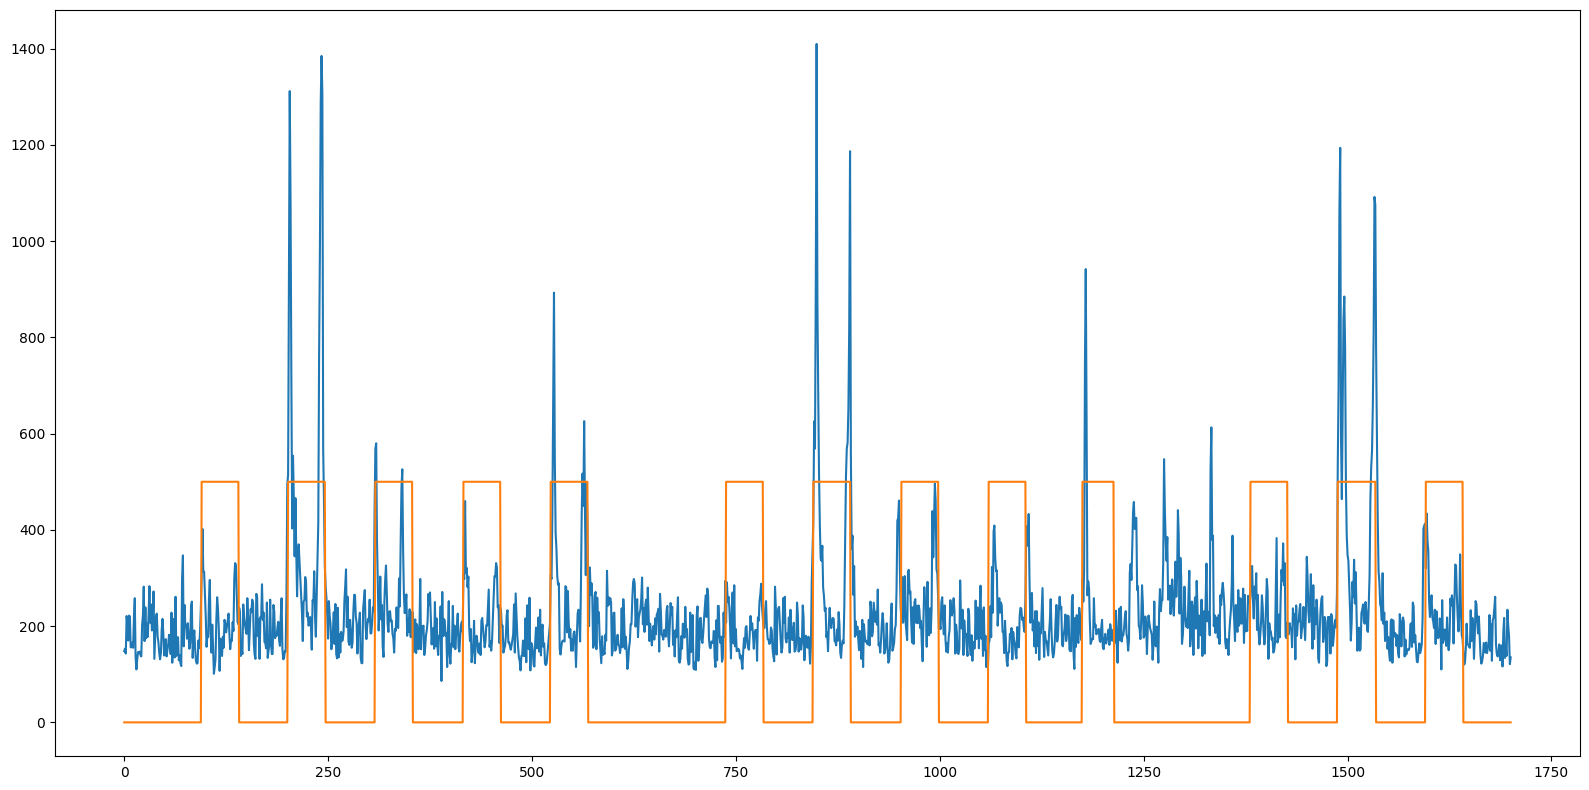

In [17]:
def data_shifter(data, n):
    """Смещает данные на n единиц

    Args:
        data: Данные
        n: Кол-во единиц

    Returns:
        X: Смещенные данные
    """
    X = data.drop('gesture', axis=1) #Матрица наблюдений
    y = data['gesture'] #Вектор правильных ответов
    #Смещаем данные
    X = X.iloc[n:].reset_index(drop=True)
    X['gesture'] = y.iloc[:-n].reset_index(drop=True)
    return X

def get_sum_derivative(data):
    """Возвращает сумму абсолютных значений производных

    Args:
        data: Наши данные

    Returns:
        result: Серия сумм абсолютных значений производных
    """
    result = abs(data.drop('gesture', axis=1).diff()).sum(axis=1)
    return result

def get_best_shifter(data, res_plot=False):
    #Формируем ряд выполнения жестов.
    gestures = data['gesture'].apply(lambda x: 500 if x > 0 else 0)
    #Ряд производных
    derivatives = get_sum_derivative(data)
    #Словарь с результатом
    result = {'n': 0, 'cor': 0}
    #Находим лучший шифтер
    for n in range(1, 41):
        cor = np.corrcoef(derivatives.iloc[n:].values, gestures.iloc[:-n].values)[0][1]
        if cor > result['cor']:
            result['n'] = n
            result['cor'] = cor
            
    if res_plot: #Если необходимо строим график с полученным сдвигом для первых 2000 таймстепов.
        fig, axes = plt.subplots(1, 1, figsize=(16, 8))
        sns.lineplot(derivatives.iloc[result['n']:].values[300:2001], ax=axes, legend=False)
        sns.lineplot(gestures.iloc[:-result['n']].values[300:2001], ax=axes, legend=False)
        plt.tight_layout()
    #Выводим результат    
    print(f'n: {result["n"]}, cor: {result["cor"]}')
    #Возвращаем словарь с найденным n и корреляцией
    return result
    
#Применяем полученную функцию
n = get_best_shifter(gestures2, res_plot=True)['n']

#experiment.log_figure(figure=plt)

In [18]:
#Теперь к нашим данным применяем функцию data_shifter со значением n равным тому, что получили при использовании get_best_shifter.
#Применяем функцию
data = data_shifter(gestures2, n)
drop_features = ['ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'ts']
data = data.drop(drop_features, axis=1)
print(f'Data shape: {data.shape}')

Data shape: (19550, 51)


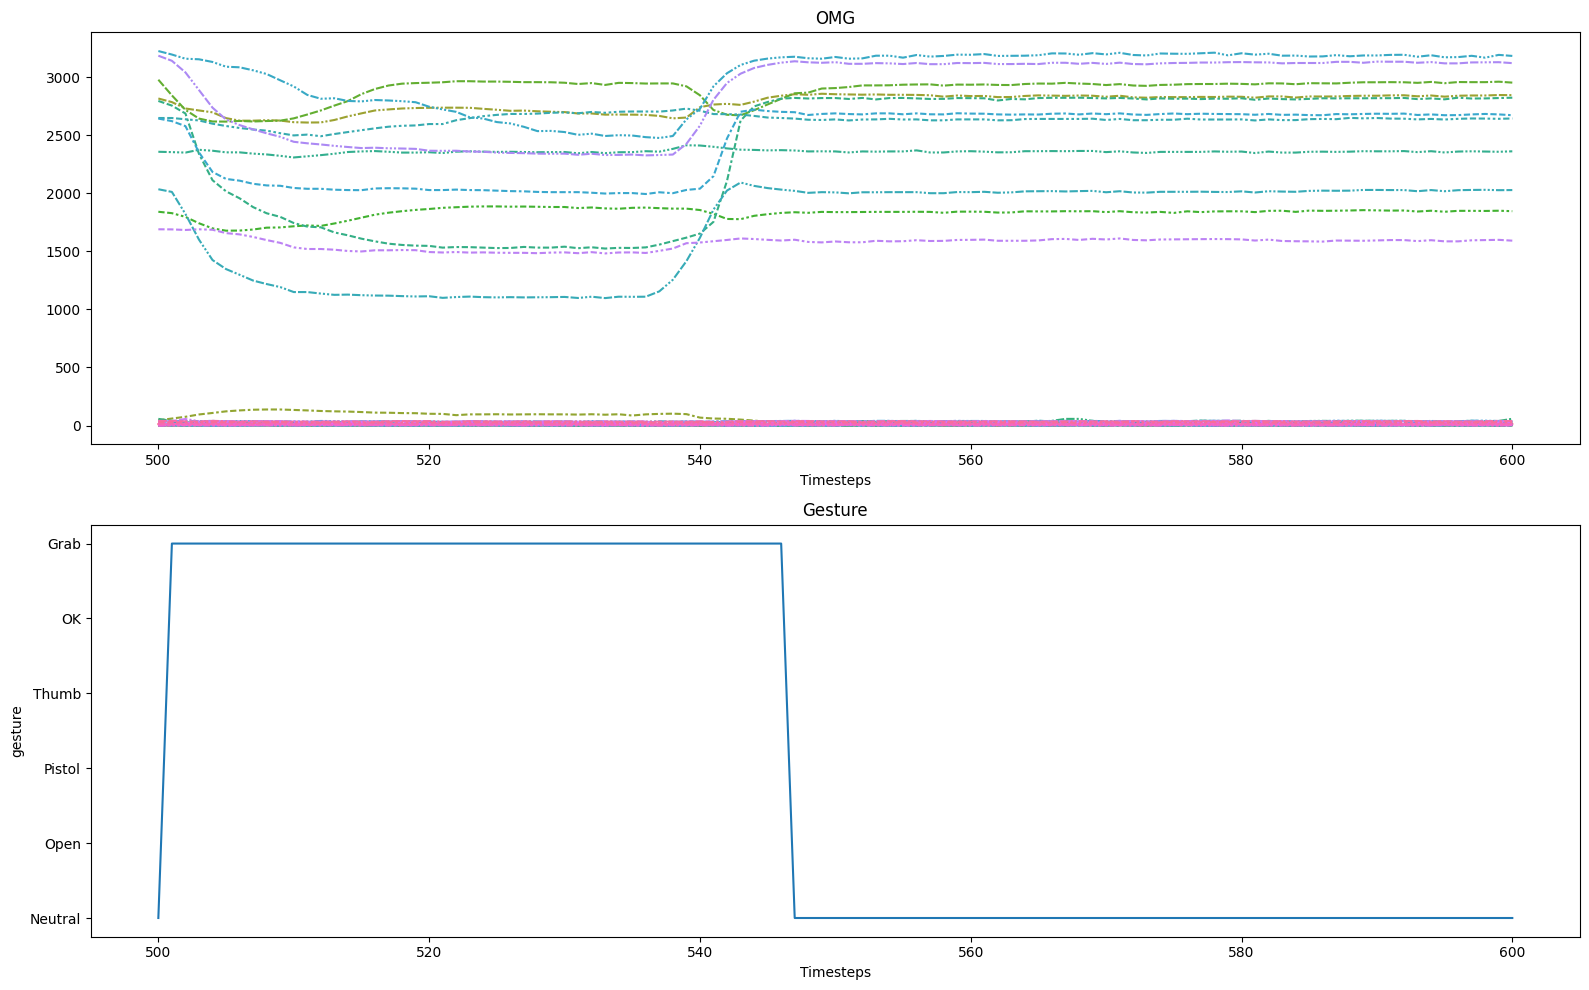

In [19]:
sample_number = 5

#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data.drop('gesture', axis=1).iloc[100 * sample_number: 100 * (sample_number + 1) + 1], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data['gesture'].iloc[100 * sample_number:100 * (sample_number + 1) + 1], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

#experiment.log_figure(figure=plt)

In [20]:
#Теперь к нашим данным применяем функцию data_shifter со значением n равным тому, что получили при использовании get_best_shifter.
#Применяем функцию
gestures = data_shifter(gestures2, n)

#drop_features = ['gesture']
#gestures = gestures.drop(drop_features, axis=1)

print(f'Data shape: {gestures.shape}')

Data shape: (19550, 65)


# Train-test split

In [21]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta.head()

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441


In [22]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15679

## Новые признаки

In [23]:
"""#!!!
def generate_complex_features(data):
    # Инициализация нового DataFrame
    features = pd.DataFrame()
    
    # Производные
    for col in data.columns:
        features[f'{col}_diff'] = data[col].diff().fillna(0)  # первое значение NaN заполняем 0
    
    # Скользящее среднее
    window_size = 3
    for col in data.columns:
        features[f'{col}_rolling_mean'] = data[col].rolling(window=window_size).mean().fillna(method='bfill')
    
    # Скользящая стандартная девиация
    for col in data.columns:
        features[f'{col}_rolling_std'] = data[col].rolling(window=window_size).std().fillna(method='bfill')
    
    return features

# Применение функции к данным
complex_features = generate_complex_features(gestures[OMG_CH])
gestures = pd.concat([gestures, complex_features], axis=1)
"""

"#!!!\ndef generate_complex_features(data):\n    # Инициализация нового DataFrame\n    features = pd.DataFrame()\n    \n    # Производные\n    for col in data.columns:\n        features[f'{col}_diff'] = data[col].diff().fillna(0)  # первое значение NaN заполняем 0\n    \n    # Скользящее среднее\n    window_size = 3\n    for col in data.columns:\n        features[f'{col}_rolling_mean'] = data[col].rolling(window=window_size).mean().fillna(method='bfill')\n    \n    # Скользящая стандартная девиация\n    for col in data.columns:\n        features[f'{col}_rolling_std'] = data[col].rolling(window=window_size).std().fillna(method='bfill')\n    \n    return features\n\n# Применение функции к данным\ncomplex_features = generate_complex_features(gestures[OMG_CH])\ngestures = pd.concat([gestures, complex_features], axis=1)\n"

In [24]:
# Определяем колонки, которые будут использоваться в модели
feature_columns = OMG_CH#+ [f'{col}_diff' for col in OMG_CH] + [f'{col}_rolling_mean' for col in OMG_CH]# + [f'{col}_rolling_std' for col in OMG_CH]

# Теперь создаем тренировочные и тестовые данные
X_train = gestures[feature_columns].iloc[:last_train_idx].values
X_test = gestures[feature_columns].iloc[last_train_idx:].values

# мой старый вариант
y_train = y_cmd[:last_train_idx]
y_test = y_cmd[last_train_idx:]

# адаптация к задержке
y_train = gestures['gesture'][:last_train_idx]
y_test= gestures['gesture'][last_train_idx:]


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15679, 50) (15679,)
(3871, 50) (3871,)


## экспоненциального сглаживание

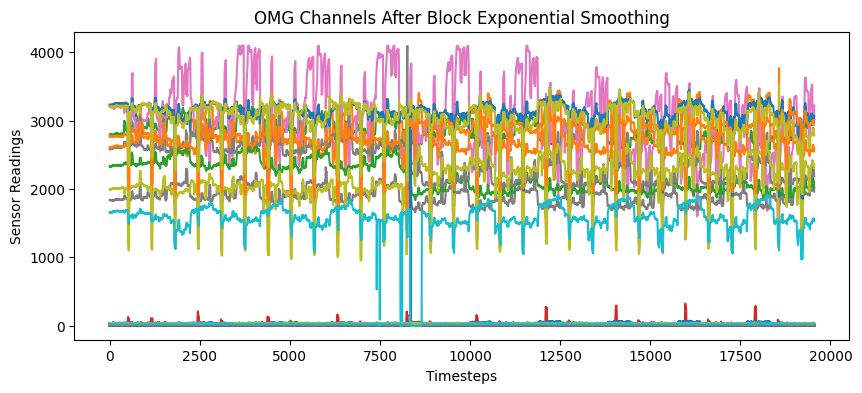

In [25]:
import numpy as np
import pandas as pd

# Функция для экспоненциального сглаживания с блочной обработкой
def block_ewm(data, alpha=0.3, block_size=100):
    num_blocks = (len(data) + block_size - 1) // block_size  # Определяем количество блоков
    smoothed_data = np.zeros_like(data)
    
    # Применяем экспоненциальное сглаживание для каждого блока данных
    for i in range(num_blocks):
        start_idx = i * block_size
        end_idx = min((i + 1) * block_size, len(data))
        smoothed_data[start_idx:end_idx] = data[start_idx:end_idx].ewm(alpha=alpha, adjust=False).mean()
    
    return smoothed_data

# Применяем блочное сглаживание ко всем каналам OMG
for column in OMG_CH:
    gestures[column] = block_ewm(gestures[column])

# Визуализация сглаженных данных
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG Channels After Block Exponential Smoothing')
plt.xlabel('Timesteps')
plt.ylabel('Sensor Readings')
plt.show()


In [26]:
"""#!!! import pandas as pd

# Применение экспоненциального сглаживания к каждой колонке
alpha = 0.3  # Коэффициент сглаживания
for column in OMG_CH:
    gestures[column] = gestures[column].ewm(alpha=alpha, adjust=False).mean()"""


'#!!! import pandas as pd\n\n# Применение экспоненциального сглаживания к каждой колонке\nalpha = 0.3  # Коэффициент сглаживания\nfor column in OMG_CH:\n    gestures[column] = gestures[column].ewm(alpha=alpha, adjust=False).mean()'

In [27]:
import numpy as np

# Преобразование Фурье для каждой колонки
def apply_fft(data):
    fft_values = np.fft.fft(data)
    return np.abs(fft_values)  # Взятие модуля комплексных чисел для получения амплитуд

for column in OMG_CH:
    gestures[column] = apply_fft(gestures[column])


## стандартизация

под вопросом применения, проблемы на онлайн тесте..... если делать, то только для онлайн

In [28]:
from sklearn.preprocessing import StandardScaler
# !!!Создание экземпляра нормализатора
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Modeling

In [29]:
from tensorflow.keras.utils import to_categorical
# Преобразуем метки в категориальный формат
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [30]:
# Приведение X_test к float32 и проверка формы данных
X_test = X_test.astype('float32')
print("X_test shape:", X_test.shape)

# Проверка типа данных y_test_categorical
print("y_test_categorical dtype:", y_test_categorical.dtype)

# Если y_test_categorical не float32, приведем его к этому типу
y_test_categorical = y_test_categorical.astype('float32')


X_test shape: (3871, 50)
y_test_categorical dtype: float32


In [31]:
# Добавляем измерение временных шагов
X_test = np.expand_dims(X_test, axis=1)
X_train = np.expand_dims(X_train, axis=1)

print("New X_train shape:", X_train.shape)
print("New X_test shape:", X_test.shape)

New X_train shape: (15679, 1, 50)
New X_test shape: (3871, 1, 50)


In [32]:
# прошлые значения в третье измерение (переобучает медель)
"""def create_lagged_features(X, n_steps):
    X_lagged = np.zeros((X.shape[0], n_steps, X.shape[1]))
    for i in range(n_steps):
        # Сдвигаем данные на i шагов во времени
        X_lagged[:, i, :] = np.roll(X, shift=i, axis=0)
        # Обнуляем начало данных, где не хватает истории
        X_lagged[:i, i, :] = 0
    
    return X_lagged

# Создаем данные с тремя временными лагами
n_steps = 3
X_train = create_lagged_features(X_train, n_steps)
X_test = create_lagged_features(X_test, n_steps)
print("New shape with lags:", X_train.shape)"""


'def create_lagged_features(X, n_steps):\n    X_lagged = np.zeros((X.shape[0], n_steps, X.shape[1]))\n    for i in range(n_steps):\n        # Сдвигаем данные на i шагов во времени\n        X_lagged[:, i, :] = np.roll(X, shift=i, axis=0)\n        # Обнуляем начало данных, где не хватает истории\n        X_lagged[:i, i, :] = 0\n    \n    return X_lagged\n\n# Создаем данные с тремя временными лагами\nn_steps = 3\nX_train = create_lagged_features(X_train, n_steps)\nX_test = create_lagged_features(X_test, n_steps)\nprint("New shape with lags:", X_train.shape)'

!!!хайдроп для гиперпараметров

++чедлер для уменьшения лернинг рейт
++one circle

добавить логирование, историю тестов

++ уменьшить количество нейронов

^дисбаланс классов

^признаки из прошлых значений 

логирование

In [33]:
# 2

from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
import numpy as np

# Функция для изменения learning rate
def lr_schedule(epoch):
    """
    Функция для динамического изменения learning rate.
    Здесь можно определить любое расписание изменения learning rate в зависимости от номера эпохи.
    """
    learning_rate = 0.001  # Начальная скорость обучения
    if epoch > 50:
        learning_rate = 0.0001  # Уменьшаем learning rate после 50 эпох
    return learning_rate

# Проверяем размерность и изменяем её при необходимости
if len(X_train.shape) == 2:
    X_train = np.expand_dims(X_train, axis=1)

print("Shape of X_train after reshaping:", X_train.shape)

# Преобразуем метки в категориальный формат
#y_train_categorical = to_categorical(y_train)
#y_test_categorical = to_categorical(y_test)

# Определяем и компилируем оригинальную модель
model = Sequential([
    GRU(64, input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(0.5),
    GRU(32, return_sequences=False),
    Dropout(0.5),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

# Компиляция с метриками
model.compile(
    loss="categorical_crossentropy",
    optimizer='adamax',
    metrics=['accuracy', Precision(), Recall()]
)

# Клонирование модели
m = clone_model(model)
m.compile(
    loss="categorical_crossentropy",
    optimizer='adamax',
    metrics=['accuracy', Precision(), Recall()]
)

# Колбэк для ранней остановки
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Создание колбэка LearningRateScheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Обучение модели
history = m.fit(
    X_train, y_train_categorical,
    batch_size=5,
    epochs=400,
    validation_split=0.25,
    callbacks=[early_stopping, lr_scheduler],
    verbose=0
)

# Оценка модели
results = m.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {results[0]}")
print(f"Accuracy: {results[1]}")
print(f"Precision: {results[2]}")
print(f"Recall: {results[3]}")

# Предсказание
y_pred_train_nn = m.predict(X_train)
print(y_pred_train_nn.shape)


Shape of X_train after reshaping: (15679, 1, 50)
121/121 [==============================] - 0s 475us/step - loss: 0.4903 - accuracy: 0.8466 - precision_1: 0.8700 - recall_1: 0.8264
Test Loss: 0.4903385043144226
Accuracy: 0.8465512990951538
Precision: 0.8700027465820312
Recall: 0.8264014720916748
490/490 [==============================] - 0s 347us/step
(15679, 6)


In [ ]:
# с 200 признаками
"""Test Loss: 0.3759869337081909
Accuracy: 0.892275869846344
Precision: 0.905530571937561
Recall: 0.8840093016624451"""

In [ ]:
#со 150 признаками
"""Test Loss: 0.3692825138568878
Accuracy: 0.8933092355728149
Precision: 0.9075697064399719
Recall: 0.8827176690101624"""

In [ ]:
# с новой задержкой
"""Test Loss: 0.403143048286438
Accuracy: 0.881942629814148
Precision: 0.8968633413314819
Recall: 0.8716093897819519"""

In [ ]:
"""Test Loss: 0.7887479066848755
Accuracy: 0.7554641366004944
Precision: 0.7629767060279846
Recall: 0.7408074140548706"""

### 12345

In [ ]:
# 1
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
import numpy as np

# Проверяем размерность и изменяем её при необходимости
if len(X_train.shape) == 2:
    X_train = np.expand_dims(X_train, axis=1)

print("Shape of X_train after reshaping:", X_train.shape)

# Преобразуем метки в категориальный формат
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Определяем и компилируем оригинальную модель
model = Sequential([
    GRU(64, input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(0.5),
    GRU(32, return_sequences=False),
    Dropout(0.5),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

# Компиляция с метриками
model.compile(
    loss="categorical_crossentropy",
    optimizer='adamax',
    metrics=['accuracy', Precision(), Recall()]
)

# Клонирование модели
m = clone_model(model)
m.compile(
    loss="categorical_crossentropy",
    optimizer='adamax',
    metrics=['accuracy', Precision(), Recall()]
)

# Колбэк для ранней остановки
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Создание колбэка ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   # уменьшает скорость в 5 раз
    patience=5,   # кол-во эпох без улучшений после которых произойдет изменение
    min_lr=0.0001 # минимальная скорость обучения
)

# Обучение модели
history = m.fit(
    X_train, y_train_categorical,
    batch_size=5,
    epochs=400,
    validation_split=0.25,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

# Оценка модели
results = m.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {results[0]}")
print(f"Accuracy: {results[1]}")
print(f"Precision: {results[2]}")
print(f"Recall: {results[3]}")

# Предсказание
y_pred_train_nn = m.predict(X_train)
print(y_pred_train_nn.shape)


Shape of X_train after reshaping: (15679, 1, 100)
122/122 [==============================] - 0s 681us/step - loss: 0.7950 - accuracy: 0.7498 - precision_11: 0.7553 - recall_11: 0.7334
Test Loss: 0.7950058579444885
Accuracy: 0.7498071193695068
Precision: 0.7552965879440308
Recall: 0.7333504557609558
490/490 [==============================] - 0s 452us/step
(15679, 6)


In [ ]:
#3
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
import numpy as np

# Проверяем размерность и изменяем её при необходимости
if len(X_train.shape) == 2:
    X_train = np.expand_dims(X_train, axis=1)

print("Shape of X_train after reshaping:", X_train.shape)

# Преобразуем метки в категориальный формат
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Определяем и компилируем оригинальную модель
model = Sequential([
    GRU(64, input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(0.5),
    GRU(32, return_sequences=False),
    Dropout(0.5),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

# Компиляция с метриками, используя оптимизатор Adam
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(),
    metrics=['accuracy', Precision(), Recall()]
)

# Клонирование модели
m = clone_model(model)
m.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(),
    metrics=['accuracy', Precision(), Recall()]
)

# Колбэк для ранней остановки
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Создание колбэка ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   # уменьшает скорость в 5 раз
    patience=5,   # кол-во эпох без улучшений после которых произойдет изменение
    min_lr=0.0001 # минимальная скорость обучения
)

# Обучение модели
history = m.fit(
    X_train, y_train_categorical,
    batch_size=5,
    epochs=400,
    validation_split=0.25,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

# Оценка модели
results = m.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {results[0]}")
print(f"Accuracy: {results[1]}")
print(f"Precision: {results[2]}")
print(f"Recall: {results[3]}")

# Предсказание
y_pred_train_nn = m.predict(X_train)
print(y_pred_train_nn.shape)


### Metrics

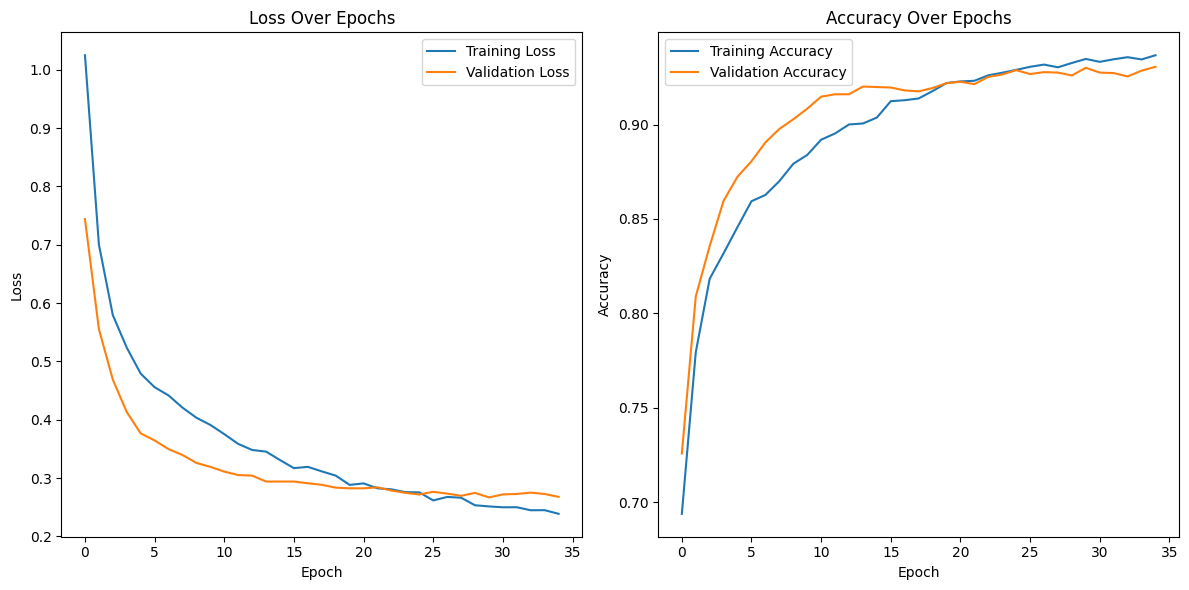

In [34]:
# Визуализация истории обучения
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import numpy as np

y_train_labels = np.argmax(y_train_categorical, axis=1) if y_train_categorical.ndim > 1 else y_train
y_test_labels = np.argmax(y_test_categorical, axis=1) if y_test_categorical.ndim > 1 else y_test

# Предсказание вероятностей классов
y_pred_prob_train = m.predict(X_train)
y_pred_prob_test = m.predict(X_test)

# Преобразование предсказанных вероятностей в метки классов
y_pred_train_classes = np.argmax(y_pred_prob_train, axis=1)
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)

# Вывод метрик классификации для обучающего набора
train_classification_report = classification_report(y_train_labels, y_pred_train_classes, target_names=GESTURES)
print("Classification report for training data:\n", train_classification_report)

# Вывод метрик классификации для тестового набора
test_classification_report = classification_report(y_test_labels, y_pred_test_classes, target_names=GESTURES)
print("Classification report for test data:\n", test_classification_report)


121/121 [==============================] - 0s 343us/step
Classification report for training data:
               precision    recall  f1-score   support

     Neutral       0.95      0.97      0.96     10151
        Open       0.96      0.84      0.90      1104
      Pistol       0.96      0.91      0.93      1098
       Thumb       0.94      0.87      0.91      1104
          OK       0.90      0.89      0.89      1104
        Grab       0.94      0.96      0.95      1118

    accuracy                           0.95     15679
   macro avg       0.94      0.91      0.92     15679
weighted avg       0.95      0.95      0.95     15679

Classification report for test data:
               precision    recall  f1-score   support

     Neutral       0.92      0.88      0.90      2490
        Open       0.96      0.80      0.87       276
      Pistol       0.66      0.96      0.78       276
       Thumb       0.86      0.41      0.56       276
          OK       0.56      0.91      0.69      

In [ ]:
"""
               precision    recall  f1-score   support

     Neutral       0.96      0.98      0.97     10151
        Open       0.99      0.89      0.94      1104
      Pistol       0.96      0.93      0.94      1098
       Thumb       0.94      0.87      0.91      1104
          OK       0.89      0.90      0.89      1104
        Grab       0.96      0.96      0.96      1118

    accuracy                           0.95     15679
   macro avg       0.95      0.92      0.93     15679
weighted avg       0.96      0.95      0.95     15679

Classification report for test data:
               precision    recall  f1-score   support

     Neutral       0.94      0.93      0.93      2490
        Open       0.97      0.89      0.93       276
      Pistol       0.80      0.95      0.87       276
       Thumb       0.79      0.49      0.61       276
          OK       0.67      0.89      0.76       276
        Grab       0.90      0.89      0.90       277
...
    accuracy                           0.89      3871
   macro avg       0.85      0.84      0.83      3871
weighted avg       0.90      0.89      0.89      3871"""

'\n               precision    recall  f1-score   support\n\n     Neutral       0.96      0.98      0.97     10151\n        Open       0.99      0.89      0.94      1104\n      Pistol       0.96      0.93      0.94      1098\n       Thumb       0.94      0.87      0.91      1104\n          OK       0.89      0.90      0.89      1104\n        Grab       0.96      0.96      0.96      1118\n\n    accuracy                           0.95     15679\n   macro avg       0.95      0.92      0.93     15679\nweighted avg       0.96      0.95      0.95     15679\n\nClassification report for test data:\n               precision    recall  f1-score   support\n\n     Neutral       0.94      0.93      0.93      2490\n        Open       0.97      0.89      0.93       276\n      Pistol       0.80      0.95      0.87       276\n       Thumb       0.79      0.49      0.61       276\n          OK       0.67      0.89      0.76       276\n        Grab       0.90      0.89      0.90       277\n...\n    accur

490/490 [==============================] - 0s 346us/step


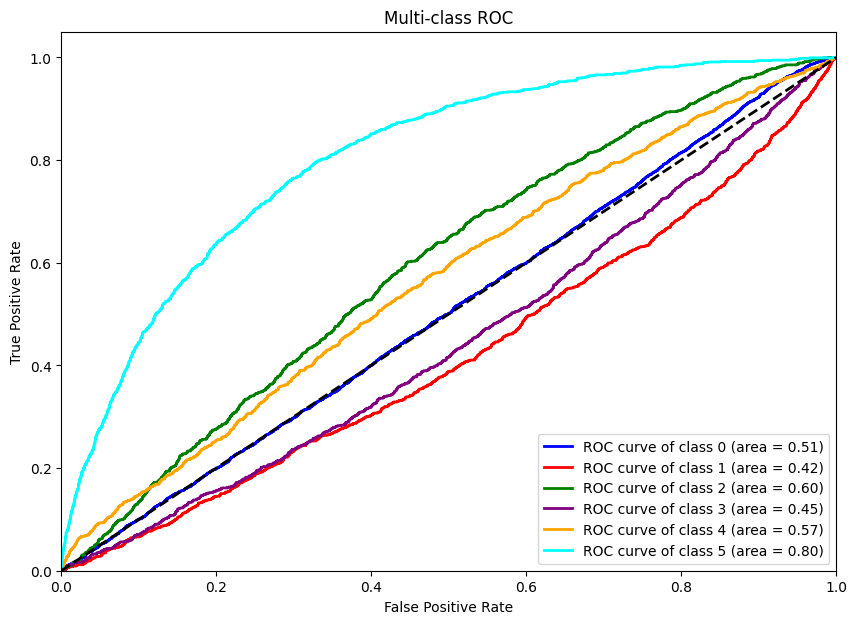

In [36]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Бинаризация меток
y_bin = label_binarize(y_train, classes=np.unique(y_train))

# Предсказание вероятностей
y_pred_prob_train = model.predict(X_train)

# Считаем ROC AUC для каждого класса
n_classes = y_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob_train[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение графика
plt.figure(figsize=(10, 7))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()


# Real-time inference

In [37]:
import time
import serial
from IPython.display import clear_output

In [38]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [39]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

In [108]:
import numpy as np старый
import pandas as pd
from sklearn.preprocessing import StandardScaler

def preprocessing(data, window_size=3, feature_columns=None):
    processed_features = []

    # Предполагаем, что data - это DataFrame, где каждая строка - это отдельный временной шаг или запись
    for index, row in data.iterrows():
        # Преобразование строки в DataFrame для обработки
        row_df = pd.DataFrame(row.values.reshape(1, -1))
        row_df.columns = [f'feature_{i}' for i in range(row_df.shape[1])]
        
        # Применяем скользящее среднее и производные
        rolling_means = row_df.rolling(window=window_size, min_periods=1).mean().fillna(method='bfill')
        differences = row_df.diff().fillna(0)

        # Обновляем названия столбцов после добавления новых признаков
        rolling_means.columns = [f'{col}_rolling_mean' for col in row_df.columns]
        differences.columns = [f'{col}_diff' for col in row_df.columns]
        
        # Комбинирование признаков
        feature_row = pd.concat([row_df, rolling_means, differences], axis=1)

        # Отбор нужных признаков если список задан
        if feature_columns:
            feature_row = feature_row[feature_columns]
        
        # Добавляем обработанные данные в список
        processed_features.append(feature_row.values.flatten())  # Flatten, чтобы сделать одномерный массив признаков для строки
        
    # Преобразуем список обработанных признаков в numpy array
    features_array = np.array(processed_features)
    
    # Нормализация
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_array)
    
    # Возвращаем данные в формате [samples, 1, features]
    return features_scaled.reshape(features_scaled.shape[0], 1, features_scaled.shape[1])

# Определение признаков, которые необходимо включить в анализ
OMG_CH = [f'feature_{i}' for i in range(50)]  # Пример списка каналов
feature_columns = OMG_CH + [f'{col}_diff' for col in OMG_CH] + [f'{col}_rolling_mean' for col in OMG_CH]



SyntaxError: invalid syntax (1058628128.py, line 1)

In [40]:
import cProfile
import pstats
def preprocessing(data, scaler, feature_columns=None):
    """
    Предобработка данных с использованием обученного масштабировщика.
    
    Args:
    data: Входные данные для предобработки
    scaler: Обученный StandardScaler
    feature_columns: Колонки, которые будут использоваться
    
    Returns:
    numpy array: Масштабированные данные
    """
    # Проверяем тип данных и преобразуем в DataFrame при необходимости
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data.reshape(1, -1))
    
    # Назначаем имена столбцов
    column_names = [f'feature_{i}' for i in range(data.shape[1])]
    data.columns = column_names

    # Фильтрация признаков, если указан список feature_columns
    if feature_columns:
        data = data[feature_columns]

    # Применение нормализации
    features_scaled = scaler.transform(data)
    
    # Возвращаем данные в формате [samples, 1, features]
    return features_scaled.reshape(features_scaled.shape[0], 1, features_scaled.shape[1])

# Пример использования функции
OMG_CH = [f'feature_{i}' for i in range(50)]  # Список названий признаков
feature_columns = OMG_CH  # Фильтрация только этих признаков



# Запуск профайлера на вашей функции
profiler = cProfile.Profile()
profiler.enable()
preprocessing(df_sim, scaler, feature_columns=feature_columns)
profiler.disable()

stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()

NameError: name 'df_sim' is not defined

In [72]:
sample_preprocessed.shape

(1, 1, 50)

In [ ]:
import numpy as np

def inference(model, x):
    """
    Производит предсказание с использованием модели и преобразует выходные данные в метки классов.

    Args:
    model: Обученная модель для предсказания.
    x: Входные данные для предсказания, ожидается, что это np.array.

    Returns:
    numpy array с метками классов.
    """
    # Убедимся, что x имеет правильную форму (n_samples, n_features)
    """    x = np.array(x)
    if x.ndim == 1:
        x = x.reshape(1, -1)
    elif x.ndim == 2:
        x = x.reshape(1, x.shape[0], x.shape[1])"""

    # Делаем предсказание
    y_pred = model.predict(x)
    
    # Преобразуем вероятности в метки классов
    y_labels = np.argmax(y_pred, axis=-1)
    return y_labels


# Запуск профайлера на вашей функции
profiler = cProfile.Profile()
profiler.enable()
inference(model, sample_preprocessed)
profiler.disable()

stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()

122/122 [==============================] - 0s 575us/step
         168921 function calls (164258 primitive calls) in 0.123 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.123    0.062 /Users/ilakamnev/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3397(run_code)
        2    0.000    0.000    0.123    0.062 {built-in method builtins.exec}
        1    0.000    0.000    0.123    0.123 /var/folders/88/7g79gm9d45d4lvwr8s3qk3jm0000gn/T/ipykernel_34246/69170469.py:3(inference)
        1    0.001    0.001    0.123    0.123 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py:59(error_handler)
        1    0.000    0.000    0.123    0.123 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:2376(predict)
 1151/516    0.001    0.000    0.076    0.000 /

## Inference

### Offline (dataset)

In [ ]:
palm_file = './data/2023-05-31_17-14-41.palm'
gestures = read_omg_csv(palm_file, 
                              n_omg_channels=50,
                              n_acc_channels=3, 
                              n_gyr_channels=3, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print(gestures.shape)

(19568, 65)


In [ ]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


In [ ]:
import cProfile
import pstats

def your_processing_function():
    # Здесь ваш код
    pass

# Запуск профайлера на вашей функции
profiler = cProfile.Profile()
profiler.enable()
your_processing_function()
profiler.disable()

stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()


In [121]:

# Применение функции с фильтрацией признаков
sample_preprocessed = preprocessing(df_sim, scaler, feature_columns=feature_columns)
#y_predicted = inference(model, sample_preprocessed)

#y_predicted.shape

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [76]:
sample_preprocessed.shape

(3889, 1, 50)

In [ ]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample, scaler, feature_columns=feature_columns)
    # [/Data preprocessing]
    
    # [Inference]
    #y_predicted         = inference(sample_preprocessed)
    y_predicted = inference(model, sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

1/1 [==============================] - 0s 11ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


AssertionError: Calculation cycle takes more than TIMEOUT, halting...

In [112]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (1013, 50)
enc_sample.shape = (1013, 6)
sample_preprocessed.shape = (1013, 1, 1, 50)
y_predicted.shape = (1013, 1)
y_postprocessed.shape = (1013, 1)
y_commands.shape = (1013, 1)


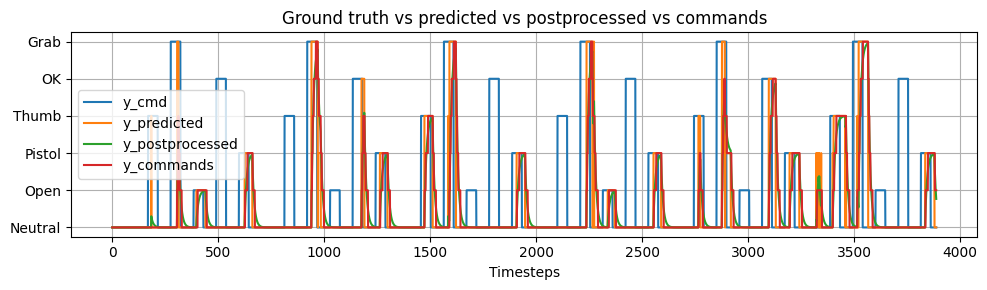

In [ ]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [ ]:
print(classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.67      0.78      0.72      2508
        Open       0.11      0.16      0.13       276
      Pistol       0.22      0.23      0.23       276
       Thumb       0.20      0.11      0.14       276
          OK       0.00      0.00      0.00       276
        Grab       0.12      0.02      0.04       277

    accuracy                           0.54      3889
   macro avg       0.22      0.22      0.21      3889
weighted avg       0.48      0.54      0.50      3889



In [ ]:
# Только с нормализацией
"""             precision    recall  f1-score   support

     Neutral       0.70      0.73      0.72      2508
        Open       0.21      0.50      0.30       276
      Pistol       0.15      0.14      0.15       276
       Thumb       0.09      0.05      0.06       276
          OK       0.03      0.01      0.02       276
        Grab       0.00      0.00      0.00       277

    accuracy                           0.52      3889
   macro avg       0.20      0.24      0.21      3889
weighted avg       0.48      0.52      0.50      3889"""

'             precision    recall  f1-score   support\n\n     Neutral       0.70      0.73      0.72      2508\n        Open       0.21      0.50      0.30       276\n      Pistol       0.15      0.14      0.15       276\n       Thumb       0.09      0.05      0.06       276\n          OK       0.03      0.01      0.02       276\n        Grab       0.00      0.00      0.00       277\n\n    accuracy                           0.52      3889\n   macro avg       0.20      0.24      0.21      3889\nweighted avg       0.48      0.52      0.50      3889'

In [ ]:
# с усреднением и нормализацией

"""              precision    recall  f1-score   support

     Neutral       0.70      0.73      0.71      2508
        Open       0.20      0.49      0.29       276
      Pistol       0.13      0.13      0.13       276
       Thumb       0.03      0.01      0.02       276
          OK       0.05      0.03      0.03       276
        Grab       0.00      0.00      0.00       277

    accuracy                           0.52      3889
   macro avg       0.18      0.23      0.20      3889
weighted avg       0.48      0.52      0.49      3889"""

'              precision    recall  f1-score   support\n\n     Neutral       0.70      0.73      0.71      2508\n        Open       0.20      0.49      0.29       276\n      Pistol       0.13      0.13      0.13       276\n       Thumb       0.03      0.01      0.02       276\n          OK       0.05      0.03      0.03       276\n        Grab       0.00      0.00      0.00       277\n\n    accuracy                           0.52      3889\n   macro avg       0.18      0.23      0.20      3889\nweighted avg       0.48      0.52      0.49      3889'

In [ ]:
"""              precision    recall  f1-score   support

     Neutral       0.67      0.80      0.73      2508
        Open       0.11      0.15      0.13       276
      Pistol       0.18      0.18      0.18       276
       Thumb       0.21      0.10      0.13       276
          OK       0.06      0.01      0.02       276
        Grab       0.10      0.02      0.04       277

    accuracy                           0.55      3889
   macro avg       0.22      0.21      0.21      3889
weighted avg       0.48      0.55      0.51      3889"""

'              precision    recall  f1-score   support\n\n     Neutral       0.67      0.80      0.73      2508\n        Open       0.11      0.15      0.13       276\n      Pistol       0.18      0.18      0.18       276\n       Thumb       0.21      0.10      0.13       276\n          OK       0.06      0.01      0.02       276\n        Grab       0.10      0.02      0.04       277\n\n    accuracy                           0.55      3889\n   macro avg       0.22      0.21      0.21      3889\nweighted avg       0.48      0.55      0.51      3889'

In [ ]:
# стандартный
"""              precision    recall  f1-score   support

     Neutral       0.67      0.78      0.72      2508
        Open       0.11      0.16      0.13       276
      Pistol       0.22      0.23      0.23       276
       Thumb       0.20      0.11      0.14       276
          OK       0.00      0.00      0.00       276
        Grab       0.12      0.02      0.04       277

    accuracy                           0.54      3889
   macro avg       0.22      0.22      0.21      3889
weighted avg       0.48      0.54      0.50      3889"""

'              precision    recall  f1-score   support\n\n     Neutral       0.67      0.78      0.72      2508\n        Open       0.11      0.16      0.13       276\n      Pistol       0.22      0.23      0.23       276\n       Thumb       0.20      0.11      0.14       276\n          OK       0.00      0.00      0.00       276\n        Grab       0.12      0.02      0.04       277\n\n    accuracy                           0.54      3889\n   macro avg       0.22      0.22      0.21      3889\nweighted avg       0.48      0.54      0.50      3889'

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

SerialException: [Errno 2] could not open port /dev/cu.usbmodem3498365F31351: [Errno 2] No such file or directory: '/dev/cu.usbmodem3498365F31351'

### тест